### Goal: The goal of this competition is to use various factors to predict obesity risk in individuals, which is related to cardiovascular disease.
### Evaluation: Submissions are evaluated using the **accuracy** score.

In [1]:
# My place is 2431 from 3587 (top 68%)
# Public Score: 0.89920
# Private score: 0.89432

### Submission File
For each id row in the test set, you must predict the class value of the target, NObeyesdad. The file should contain a header and have the following format:

| id    | NObeyesdad    |
|-------|---------------|
| 20757 | Normal_Weight |
| 20758 | Normal_Weight |
| 20759 | Normal_Weight |
| 20760 | Normal_Weight |

- id: unique identifier for each individual
- Gender: male / female
- Age: age in years
- Height: height in meters
- Weight: weight in kilograms
- family_history_with_overweight: yes / no
- FAVC: frequently consumes high caloric food: yes / no
- FCVC: frequency of consumption of vegetables: 1 to 3 (1 - never, 2 - sometimes, 3 - always)
- NCP: number of main meals: 1 to 3 (1 - one meal, 2 - two meals, 3 - three meals)
- CAEC: consumption of food between meals: 1 to 4 (1 - never, 2 - sometimes, 3 - frequently, 4 - always)
- SMOKE: yes / no
- CH2O: daily water consumption: 1 to 3 (1 - less than 1 liter, 2 - 1 to 2 liters, 3 - more than 2 liters)
- SCC: calorie consumption monitoring: yes / no
- FAF: physical activity frequency: 1 to 3 (1 - never, 2 - sometimes, 3 - always)
- TUE: time using technology devices: 1 to 4 (1 - less than 1 hour, 2 - 1 to 2 hours, 3 - 2 to 4 hours, 4 - more than 4 hours)
- CALC: consumption of alcohol: yes / no
- MTRANS: means of transportation used most often:
    - 1 - walking
    - 2 - bike
    - 3 - motorbike
    - 4 - public transportation
    - 5 - car
- NObeyesdad: the obesity level of the individual, which is the target variable to predict. The possible values are:
    - Insufficient_Weight
    - Normal_Weight
    - Overweight_Level_I
    - Overweight_Level_II
    - Obesity_Type_I
    - Obesity_Type_II
    - Obesity_Type_III

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

In [3]:
test_path = './data/obesity/test.csv'
train_path = './data/obesity/train.csv'
submission_path = './data/obesity/submission.csv'

target_column = 'NObeyesdad'

In [4]:
test_data = pd.read_csv(test_path)
train_data = pd.read_csv(train_path)

data_for_encoder = train_data[target_column].values.reshape(-1, 1)

In [5]:
train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
train_data.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [8]:
encoder = OrdinalEncoder()
train_data[target_column] = encoder.fit_transform(train_data[target_column].values.reshape(-1, 1)).ravel()

num_columns = train_data.select_dtypes(include=[np.number]).columns.tolist()

corr_matrix = train_data[num_columns].corr()

corr_matrix[target_column].sort_values(ascending=False)

NObeyesdad    1.000000
Weight        0.431821
Age           0.283018
CH2O          0.187100
Height        0.060786
FCVC          0.041076
id            0.012329
TUE          -0.076040
NCP          -0.091154
FAF          -0.096643
Name: NObeyesdad, dtype: float64

In [9]:
train_data['weight_cat'] = pd.cut(train_data['Weight'], bins=[0, 54, 68, 80, 85, 104, 121, np.inf], labels=[1, 2, 3, 4, 5, 6, 7]).astype(int) # based on weight distribution

X = train_data.drop(columns=[target_column])
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=train_data['weight_cat']
)

In [10]:
X_train['weight_cat'].value_counts() / len(X_train)

weight_cat
6    0.257377
3    0.173552
2    0.141214
1    0.128688
5    0.123871
7    0.098338
4    0.076960
Name: count, dtype: float64

In [11]:
X_test['weight_cat'].value_counts() / len(X_test)

weight_cat
6    0.257466
3    0.173651
2    0.141378
1    0.128613
5    0.123796
7    0.098266
4    0.076830
Name: count, dtype: float64

In [12]:
X_test = X_test.drop(columns=['weight_cat', 'id'])
X_train = X_train.drop(columns=['weight_cat', 'id'])

In [13]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    """ Custom transformer to create new features based on existing ones."""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """ Create new features based on existing ones."""
        # Age Cat
        X.loc[:, 'Age_cat'] = pd.cut(X['Age'], bins=[0, 12, 19, 39, 59, np.inf], labels=[1, 2, 3, 4, 5]).astype(int)

        # BMI calculation
        X.loc[:, 'BMI'] = X['Weight'] / (X['Height'] ** 2)

        # Interaction features
        X.loc[:, 'Age_BMI'] = X['Age'] * X['BMI']

        # Weight transformation
        # X['weight_cat'] = pd.cut(X['Weight'], bins=[0, 54, 68, 80, 85, 104, 121, np.inf], labels=[1, 2, 3, 4, 5, 6, 7]).astype(int)

        # Meal to vegetable ratio
        X.loc[:, 'meal_veg_ratio'] = X['NCP'] / (X['FCVC'] + 1e-3)

        # Height transformation
        X.loc[:, 'Height_group'] = pd.cut(X['Height'], bins=4, labels=False)

        # BMI Categories
        X.loc[:, 'PseudoTarget'] = pd.cut(X['BMI'],
                               bins=[0,18.5,25,30,35,40,100],
                               labels=[0,1,2,3,4,5]).astype(int)
        # Medical Risk Features
        X.loc[:, 'Metabolic_Risk'] = X['BMI'] * X['Age'] / 10
        # Lifestyle Features
        X.loc[:, 'Activity_Score'] = X['FAF'] / (X['TUE'] + 1e-3)
        return X


In [14]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=[object]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ],
    remainder='drop', n_jobs=-1
)

In [15]:
target_encoder = OrdinalEncoder()

y_test = pd.Series(target_encoder.fit_transform(y_test.values.reshape(-1, 1)).ravel(), name=target_column)
y_train = pd.Series(target_encoder.transform(y_train.values.reshape(-1, 1)).ravel(), name=target_column)

In [16]:
# Create a pipeline with custom transformer
transformer = Pipeline(steps=[
    ('feature_engineering', FeatureTransformer()),
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
best_params = {'min_samples_leaf': 50,
               'max_iter': 100,
               'max_depth': 5,
               'max_bins': 255,
               'learning_rate': 0.1,
               'l2_regularization': 0.1,
               'early_stopping': False}

pipeline = make_pipeline(transformer, HistGradientBoostingClassifier(**best_params, random_state=42, scoring='accuracy')) # F1 Test Score: 0.903 / F1 Train Score: 0.951
pipeline.fit(X_train, y_train)

best_model = pipeline

In [19]:
y_pred = best_model.predict(X_test)
f1_score_test = best_model.score(X_test, y_test)
print(f'F1 Test Score: {f1_score_test}')

F1 Test Score: 0.8998073217726397


In [20]:
y_pred_train = best_model.predict(X_train)
f1_score_train = best_model.score(X_train, y_train)
print(f'F1 Train Score: {f1_score_train}')

F1 Train Score: 0.9477899554377935


In [21]:
# let's use cross_val_predict to get cross validated predictions
y_train_pred = cross_val_predict(best_model, X_train, y_train, cv=cv, n_jobs=-1, verbose=0)

confusion_matrix(y_train, y_train_pred)

array([[1873,  129,    0,    0,    0,   11,    1],
       [ 132, 2149,    3,    0,    0,  122,   32],
       [   1,    4, 2070,   66,    8,   45,  149],
       [   0,    0,   52, 2548,    2,    0,   14],
       [   1,    0,    4,    2, 3215,    2,    0],
       [  15,  169,   40,    0,    0, 1504,  214],
       [   1,   36,  156,   14,    0,  169, 1653]])

In [22]:
precision_score(y_train, y_train_pred, average='weighted')

0.903756881035402

In [23]:
recall_score(y_train, y_train_pred, average='weighted')

0.9040105985788269

In [24]:
f1_score(y_train, y_train_pred, average='weighted')

0.9038097170127548

In [25]:
# let's use SGDClassifier to get feature importances
sgd = make_pipeline(transformer, SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42))
sgd.fit(X_train, y_train)

,steps,"[('pipeline', ...), ('sgdclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('feature_engineering', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3


In [26]:
feature_names = transformer.named_steps['preprocessor'].get_feature_names_out()
coefficients = sgd.named_steps['sgdclassifier'].coef_[0]
feature_importances = pd.Series(coefficients, index=feature_names, name='Correlation Importance').sort_values(ascending=False)
feature_importances

num__Height                                 2.689352
num__TUE                                    0.528063
cat__MTRANS_Automobile                      0.362517
cat__CAEC_Frequently                        0.322408
num__FCVC                                   0.279689
num__NCP                                    0.185100
cat__Gender_Male                            0.136021
cat__CALC_no                                0.113125
cat__FAVC_no                                0.082054
cat__SMOKE_no                               0.069268
num__CH2O                                   0.059042
num__FAF                                    0.047288
cat__SCC_no                                 0.039510
cat__family_history_with_overweight_no      0.037056
cat__CALC_Sometimes                         0.010368
cat__MTRANS_Bike                           -0.020498
cat__family_history_with_overweight_yes    -0.037056
cat__SCC_yes                               -0.039510
cat__CAEC_Sometimes                        -0.

In [27]:
# Select the first test row
test_row = X_test.iloc[100:101, :]
test_label = y_test.iloc[100:101]

# Predict using the fitted SGD pipeline
y_pred_sgd = sgd.predict(test_row)

print(f'Predicted: {y_pred_sgd[0]}, Actual: {test_label.values[0]}')

Predicted: 5.0, Actual: 1.0


In [28]:
y_scores = sgd.decision_function(test_row)
print(f'Decision Function Scores: {y_scores}')

Decision Function Scores: [[ -9.87304006  -2.41209911  -5.2854523  -62.1353243  -18.24430517
   -2.09452932  -3.78575004]]


In [29]:
y_scores = cross_val_predict(sgd, X_train, y_train, cv=cv, method='decision_function', n_jobs=-1, verbose=0)
y_scores[:5]

array([[ -21.94435461,   -1.99509469,   -7.21576288,  -84.64461573,
         -39.28210638,   -3.02313816,   -5.39381625],
       [ -46.63609475,   -5.32043645,   -2.23753502,  -58.13611599,
           2.34500029,   -3.4353815 ,   -4.24974498],
       [   4.52237167,    0.22841008,   -5.19035203, -108.65813352,
        -182.40049222,   -3.45976438,   -1.83508953],
       [ -56.85029234,   -6.28523655,   -2.28702993,  -51.42897799,
           8.03645478,   -4.16447835,   -4.78800732],
       [ -51.89581229,   -5.43722685,   -3.47124279,    4.96696603,
         -73.81496177,   -3.93274739,   -5.0387438 ]])

In [30]:
svc = make_pipeline(transformer, SVC(kernel='linear', probability=True, random_state=42))
svc.fit(X_train, y_train)

y_predicted = svc.predict(test_row)
print(f'Predicted: {y_predicted[0]}, Actual: {test_label.values[0]}')

Predicted: 1.0, Actual: 1.0


In [31]:
test_row_scores = svc.decision_function(test_row)
print(f'Decision Function Scores: {test_row_scores}')
class_predictor_idx = np.argmax(test_row_scores)
class_predictor = svc.classes_[class_predictor_idx]
print(f'Predicted Class: {class_predictor}')

Decision Function Scores: [[ 2.74645141  6.30840798  2.24710087 -0.32080782  1.72649046  5.30984794
   3.27712354]]
Predicted Class: 1.0


In [38]:
# cross validation for multinomial classification
score = cross_val_score(svc, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print(f'Cross-Validation Accuracy Scores: {score}')
mean_score = score.mean()
std_score = score.std()
print(f'Cross-Validation Accuracy: {mean_score:.4f} +/- {std_score:.4f}')

Cross-Validation Accuracy Scores: [0.86574353 0.8678109  0.86841313 0.86811201 0.87172538]
Cross-Validation Accuracy: 0.8684 +/- 0.0019


In [43]:
# error analysis
y_train_pred = cross_val_predict(best_model, X_train, y_train, cv=cv, n_jobs=-1, verbose=0)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[1873,  129,    0,    0,    0,   11,    1],
       [ 132, 2149,    3,    0,    0,  122,   32],
       [   1,    4, 2070,   66,    8,   45,  149],
       [   0,    0,   52, 2548,    2,    0,   14],
       [   1,    0,    4,    2, 3215,    2,    0],
       [  15,  169,   40,    0,    0, 1504,  214],
       [   1,   36,  156,   14,    0,  169, 1653]])

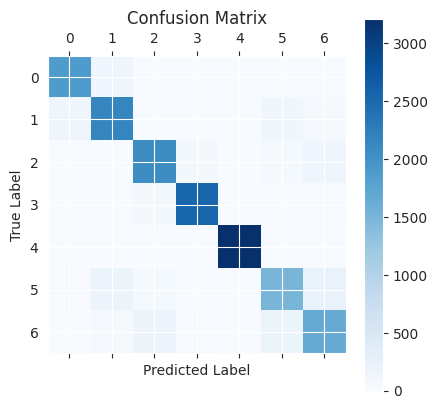

In [46]:
plt.matshow(conf_mx, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

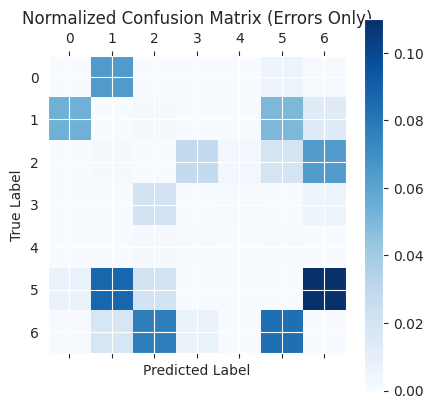

In [47]:
# normalized confusion matrix ( shows only the errors)
row_nums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_nums
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix (Errors Only)')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [33]:
# scores = cross_val_score(best_model, X_test, y_test, scoring='accuracy', cv=cv)
# mean_score = scores.mean()
# r2_score = best_model.score(X_test, y_test)
#
# print(f'Mean Test Accuracy: {mean_score}') # 0.8906467748249316
# print(f'R2 Test Score: {r2_score}') # 0.910645472061657

In [34]:
# scores = cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=cv)
# mean_score = scores.mean()
# r2_score = best_model.score(X_train, y_train)
#
# print(f'Mean Train Accuracy: {mean_score}') # 0.8906467748249316
# print(f'R2 Train Score: {r2_score}') # 0.910645472061657

In [35]:
# # let's predict on test data
# y_test_pred = best_model.predict(test_data)

In [36]:
# target_encoder.fit(data_for_encoder)

In [37]:
# # save predictions to submission file
# _id = test_data['id']
# submission_df = pd.DataFrame({'id': _id, target_column: y_test_pred})
# # let's revert target encoding
# submission_df[target_column] = target_encoder.inverse_transform(
#     y_test_pred.reshape(-1, 1)
# ).ravel()
# submission_df.to_csv(submission_path, index=False)